In [317]:
import sys
!{sys.executable} -m pip install duckdb-engine
!{sys.executable} -m pip install ipython-sql

In [318]:
import requests
from bs4 import BeautifulSoup

import pandas as pd
import numpy as np
import time

import seaborn
from matplotlib import pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn import utils

In [319]:
%load_ext sql

%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

%sql duckdb:///:memory:

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


Research Question: Does there exist correlation between the popularity of Pitbull’s music (measured through Billboard awards and spots on Billboard Hot 100) with American unemployment since his breakthrough in 2009 to 2021?

Source datasets:
https://www.kaggle.com/datasets/dhruvildave/billboard-the-hot-100-songs
https://en.wikipedia.org/wiki/List_of_awards_and_nominations_received_by_Pitbull
https://www.kaggle.com/code/qusaybtoush1990/us-unemployment-data-1948-2021

### Billboard Hot 100 Data Cleaning:

In [320]:
billboard_df = pd.read_csv('charts.csv')
print (billboard_df.head())

         date  rank           song                         artist  last-week  \
0  2021-11-06     1     Easy On Me                          Adele        1.0   
1  2021-11-06     2           Stay  The Kid LAROI & Justin Bieber        2.0   
2  2021-11-06     3  Industry Baby        Lil Nas X & Jack Harlow        3.0   
3  2021-11-06     4     Fancy Like                   Walker Hayes        4.0   
4  2021-11-06     5     Bad Habits                     Ed Sheeran        5.0   

   peak-rank  weeks-on-board  
0          1               3  
1          1              16  
2          1              14  
3          3              19  
4          2              18  


In [321]:
pitbull_df= billboard_df.loc[billboard_df['artist'] == 'Pitbull']

In [322]:
pitbull_df= pitbull_df.loc[pitbull_df['date'].between('2009-01-01', '2022-10-15')]
%sql SELECT * FROM pitbull_df ORDER BY date ASC

,date,rank,song,artist,last-week,peak-rank,weeks-on-board
0,2009-03-14,66,I Know You Want Me (Calle Ocho),Pitbull,NaN,66,1
1,2009-03-21,54,I Know You Want Me (Calle Ocho),Pitbull,66.0,54,2
2,2009-03-28,50,I Know You Want Me (Calle Ocho),Pitbull,54.0,50,3
3,2009-04-04,44,I Know You Want Me (Calle Ocho),Pitbull,50.0,44,4
4,2009-04-11,37,I Know You Want Me (Calle Ocho),Pitbull,44.0,37,5
...,...,...,...,...,...,...,...
79,2012-08-04,50,Back In Time,Pitbull,38.0,11,16
80,2012-08-11,55,Back In Time,Pitbull,50.0,11,17
81,2012-08-18,66,Back In Time,Pitbull,55.0,11,18
82,2012-08-25,75,Back In Time,Pitbull,66.0,11,19


The initial data cleaning meant cutting down the Kaggle csv to the dates where Pitbull appears on the Hot100, so we begin in 2009.

### Webscraping and data cleaning Pitbull's awards

This involved webscraping Pitbull's award page on Wikipedia. Because we're using the Hot100 as a popularity metric, it made sense to use Billboard Awards as a success metric. Here, we combined the Billboard Latin Awards with the Billboard America Awards to give a fuller picture of Pitbull as an artist. We implemented a binary to ask later down the line if his success in the Latin awards could have any impact on whether or not there was a correlation with unemployment.

In [323]:
page= requests.get('https://en.wikipedia.org/wiki/List_of_awards_and_nominations_received_by_Pitbull')
with open ('pitbull_awards.html', 'w', errors='replace') as writer:
    writer.write (page.text)
with open ('pitbull_awards.html', 'r') as reader:
    pitbull_awards_source = reader.read()
pitbull_awards_page= BeautifulSoup(pitbull_awards_source, 'html.parser')
table= pitbull_awards_page.find_all(['table'], class_= 'wikitable plainrowheaders')
pitbull_awards_df= pd.read_html(str(table))
pitbull_billboard_awards_df=pd.DataFrame(pitbull_awards_df[2])
print (pitbull_billboard_awards_df.head())
pitbull_latin_billboard_awards_df=pd.DataFrame(pitbull_awards_df[3])
print (pitbull_latin_billboard_awards_df.head())

      Year        Nominee / work             Award     Result
0  2011[4]               Pitbull  Top Latin Artist  Nominated
1  2011[4]            "Bon, Bon"    Top Latin Song        Won
2  2012[5]               Pitbull  Top Latin Artist  Nominated
3  2012[5]  "Give Me Everything"    Top Radio Song        Won
4  2012[5]  "Give Me Everything"      Top Rap Song  Nominated
      Year                     Nominee / work  \
0  2009[6]                            Pitbull   
1  2010[7]                            Pitbull   
2  2010[7]  "I Know You Want Me (Calle Ocho)"   
3     2011                            Pitbull   
4     2011                            Pitbull   

                                           Award     Result  
0      Latin Digital Download Artist of the Year        Won  
1  Latin Rhythm Airplay Artist of the Year, Solo  Nominated  
2          Latin Rhythm Airplay Song of the Year  Nominated  
3                                      Social 50  Nominated  
4                      

In [324]:
pitbull_latin_billboard_awards_df['Latin']= 'Yes'
pitbull_billboard_awards_df['Latin']= 'No'
pitbull_billboard_all_awards_df = pd.concat([pitbull_billboard_awards_df, pitbull_latin_billboard_awards_df], ignore_index=True)
pitbull_billboard_all_awards_df['Year'] = pitbull_billboard_all_awards_df['Year'].str[:4]
pd.to_datetime(pitbull_billboard_all_awards_df.Year, format='%Y')
pitbull_billboard_all_awards_df=pitbull_billboard_all_awards_df.sort_values(by='Year',ascending=True)
pitbull_billboard_all_awards_df.head(10)
#print(pitbull_billboard_all_awards_df)

,Year,Nominee / work,Award,Result,Latin
11,2009,Pitbull,Latin Digital Download Artist of the Year,Won,Yes
13,2010,"""I Know You Want Me (Calle Ocho)""",Latin Rhythm Airplay Song of the Year,Nominated,Yes
12,2010,Pitbull,"Latin Rhythm Airplay Artist of the Year, Solo",Nominated,Yes
0,2011,Pitbull,Top Latin Artist,Nominated,No
18,2011,"""Bon, Bon""",Latin Rhythm Airplay,Nominated,Yes
17,2011,"""Bon, Bon""",Latin Digital Download of the Year,Nominated,Yes
16,2011,Pitbull,Latin Rhythm Albums,Nominated,Yes
15,2011,Pitbull,Latin Rhythm Airplay,Nominated,Yes
14,2011,Pitbull,Social 50,Nominated,Yes
19,2011,"""Armando""",Latin Rhythm Albums,Nominated,Yes


In [325]:
pitbull_df.sort_values(by='date')

,date,rank,song,artist,last-week,peak-rank,weeks-on-board
66065,2009-03-14,66,I Know You Want Me (Calle Ocho),Pitbull,NaN,66,1
65953,2009-03-21,54,I Know You Want Me (Calle Ocho),Pitbull,66.0,54,2
65849,2009-03-28,50,I Know You Want Me (Calle Ocho),Pitbull,54.0,50,3
65743,2009-04-04,44,I Know You Want Me (Calle Ocho),Pitbull,50.0,44,4
65636,2009-04-11,37,I Know You Want Me (Calle Ocho),Pitbull,44.0,37,5
...,...,...,...,...,...,...,...
48349,2012-08-04,50,Back In Time,Pitbull,38.0,11,16
48254,2012-08-11,55,Back In Time,Pitbull,50.0,11,17
48165,2012-08-18,66,Back In Time,Pitbull,55.0,11,18
48074,2012-08-25,75,Back In Time,Pitbull,66.0,11,19


Question is: As unemployment rate changes, what is the likelihood that Pitbull has a song on the Billboard 100?

Since unemployment is calculated on a monthly basis through household surveys, we will be creating a binary variable where 1 = Pitbull appeared on the BB100 chart that month, and 0 otherwise.


### Data Cleaning Unemployment Data

In [326]:
unemployment_df = pd.read_csv('unemployment_rate_data.csv')
unemployment_df['date'] =  pd.to_datetime(unemployment_df['date'], infer_datetime_format= True)
unemployment_df.loc[unemployment_df['date'].between('2009-01-01', '2021-10-01')]

,date,unrate,unrate_men,unrate_women,unrate_16_to_17,unrate_18_to_19,unrate_20_to_24,unrate_25_to_34,unrate_35_to_44,unrate_45_to_54,unrate_55_over
732,2009-01-01,8.5,9.7,7.0,20.8,21.7,13.5,9.2,7.4,6.7,5.9
733,2009-02-01,8.9,10.4,7.2,22.8,22.7,13.8,9.8,7.5,7.2,6.1
734,2009-03-01,9.0,10.6,7.3,23.6,20.4,13.9,10.0,7.8,7.2,6.6
735,2009-04-01,8.6,9.9,7.1,21.8,20.4,13.7,9.6,7.5,6.6,6.2
736,2009-05-01,9.1,10.2,7.7,24.2,23.3,15.5,10.1,7.5,6.5,6.3
...,...,...,...,...,...,...,...,...,...,...,...
881,2021-06-01,6.1,6.1,6.1,15.0,12.3,9.9,6.5,5.2,4.6,5.0
882,2021-07-01,5.7,5.5,5.8,12.8,9.9,9.5,6.3,4.8,4.0,4.6
883,2021-08-01,5.3,5.1,5.5,10.7,11.0,9.1,5.8,4.4,4.2,4.1
884,2021-09-01,4.6,4.6,4.5,9.2,12.6,7.7,5.0,3.8,3.7,3.3


In [327]:
%sql up_df << SELECT date, unrate FROM unemployment_df ORDER BY date
up_df['year'] = pd.DatetimeIndex(up_df['date']).year
up_df['month'] = pd.DatetimeIndex(up_df['date']).month
%sql up_df << SELECT unrate, year, month FROM up_df WHERE year > 2008
up_df

Returning data to local variable up_df
Returning data to local variable up_df


,unrate,year,month
0,8.5,2009,1
1,8.9,2009,2
2,9.0,2009,3
3,8.6,2009,4
4,9.1,2009,5
...,...,...,...
150,5.7,2021,7
151,5.3,2021,8
152,4.6,2021,9
153,4.3,2021,10


The intial data cleaning meant that we had to cut down the Kaggle unemployment data starting from 2009, because that's when Pitbull first appeared on the Hot100.

In [328]:
m_df=pitbull_df
m_df['month'] = pd.DatetimeIndex(m_df['date']).month
m_df['year'] = pd.DatetimeIndex(m_df['date']).year
m_df['day'] = pd.DatetimeIndex(m_df['date']).day
%sql pab_df << SELECT year, month, song, COUNT(day) AS songfreq FROM m_df GROUP BY month, year, song ORDER BY year, month
pab_df

Returning data to local variable pab_df


,year,month,song,songfreq
0,2009,3,I Know You Want Me (Calle Ocho),3
1,2009,4,I Know You Want Me (Calle Ocho),4
2,2009,5,I Know You Want Me (Calle Ocho),5
3,2009,6,I Know You Want Me (Calle Ocho),4
4,2009,7,I Know You Want Me (Calle Ocho),4
5,2009,7,Hotel Room Service,4
6,2009,8,Hotel Room Service,5
7,2009,8,I Know You Want Me (Calle Ocho),5
8,2009,9,Hotel Room Service,4
9,2009,9,I Know You Want Me (Calle Ocho),4


We need to account for the months where he did not appear on the Billboard 100:

In [329]:
pab = pab_df
pairs = set(tuple(x) for x in pab[['year', 'month']].values.tolist())
#print(pairs)
for year in range(2009, 2013):
    for month in range(1, 13):
        if (year, month) not in pairs:
            pab = pab.append({'year': int(year), 'month': int(month)}, ignore_index=True)
pab = pab.sort_values(by=['year', 'month'])
pab = pab.reset_index(drop=True)
pab = pab.fillna(0.0)
pab['year'] = pab['year'].astype(int)
pab['month'] = pab['month'].astype(int)
pab['appearance']=pab['songfreq']>0
pab=pab.replace(to_replace=False,value=0)
pab=pab.replace(to_replace=True,value=1)
pab_df=pab
pab_df

C:\Users\yasmi\AppData\Local\Temp\ipykernel_11896\3880801372.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pab = pab.append({'year': int(year), 'month': int(month)}, ignore_index=True)
C:\Users\yasmi\AppData\Local\Temp\ipykernel_11896\3880801372.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pab = pab.append({'year': int(year), 'month': int(month)}, ignore_index=True)
C:\Users\yasmi\AppData\Local\Temp\ipykernel_11896\3880801372.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pab = pab.append({'year': int(year), 'month': int(month)}, ignore_index=True)
C:\Users\yasmi\AppData\Local\Temp\ipykernel_11896\3880801372.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a fut

,year,month,song,songfreq,appearance
0,2009,1,0,0.0,0
1,2009,2,0,0.0,0
2,2009,3,I Know You Want Me (Calle Ocho),3.0,1
3,2009,4,I Know You Want Me (Calle Ocho),4.0,1
4,2009,5,I Know You Want Me (Calle Ocho),5.0,1
5,2009,6,I Know You Want Me (Calle Ocho),4.0,1
6,2009,7,I Know You Want Me (Calle Ocho),4.0,1
7,2009,7,Hotel Room Service,4.0,1
8,2009,8,Hotel Room Service,5.0,1
9,2009,8,I Know You Want Me (Calle Ocho),5.0,1


Now that we have two dataframes that include the relevant information, month and year, we can join them to see side-by-side what the unemployment rate was for a given month, and how many times Pitbull appeared on the billboard 100 in that month (if he appeared)

In [330]:
%sql simplecomp_df << SELECT up_df.year, pab_df.appearance, up_df.month, up_df.unrate, pab_df.songfreq FROM up_df INNER JOIN pab_df ON up_df.year=pab_df.year
simplecomp_df.head(10)

Returning data to local variable simplecomp_df


,year,appearance,month,unrate,songfreq
0,2009,1,1,8.5,1.0
1,2009,1,2,8.9,1.0
2,2009,1,3,9.0,1.0
3,2009,1,4,8.6,1.0
4,2009,1,5,9.1,1.0
5,2009,1,6,9.7,1.0
6,2009,1,7,9.7,1.0
7,2009,1,8,9.6,1.0
8,2009,1,9,9.5,1.0
9,2009,1,10,9.5,1.0


In [331]:
%sql unemployaward_df << SELECT up_df.year, up_df.month, up_df.unrate, pitbull_billboard_all_awards_df.Latin FROM up_df INNER JOIN pitbull_billboard_all_awards_df ON up_df.year=pitbull_billboard_all_awards_df.year
unemployaward_df.head(10)

Returning data to local variable unemployaward_df


,year,month,unrate,Latin
0,2009,1,8.5,Yes
1,2009,2,8.9,Yes
2,2009,3,9.0,Yes
3,2009,4,8.6,Yes
4,2009,5,9.1,Yes
5,2009,6,9.7,Yes
6,2009,7,9.7,Yes
7,2009,8,9.6,Yes
8,2009,9,9.5,Yes
9,2009,10,9.5,Yes


### Billboard Chart Appearance, Awards, & Unemployment Rate

Logistic Regression on unemployment rate and whether or not Pitbull appeared on Billboard's Hot 100

In [332]:
simplecomp_df[['unrate','appearance']]
y= simplecomp_df['appearance']
x= simplecomp_df['unrate'].values.reshape(-1,1)
x_train = x[:-20]
x_test = x[-20:]
y_train = y[:-20]
y_test = y[-20:]
pitbull_logreg = LogisticRegression()
pitbull_logreg.fit(x_train, y_train)
print (pitbull_logreg.coef_, pitbull_logreg.intercept_)

[[-0.02779682]] [0.11984238]


<AxesSubplot:xlabel='unrate', ylabel='appearance'>

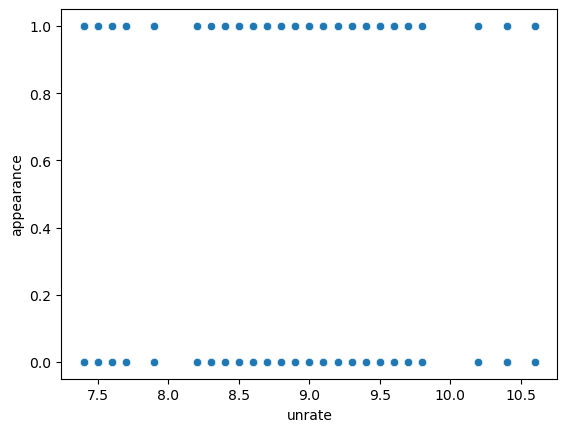

In [333]:
seaborn.scatterplot (data= simplecomp_df, x = simplecomp_df['unrate'], y = simplecomp_df['appearance'])

Logistic Regression on unemployment rate and whether or not the award Pitbull recieved in a given year was Latin or not

In [334]:
unemployaward_df[['unrate','Latin']]
y= unemployaward_df['Latin']
x= unemployaward_df['unrate'].values.reshape(-1,1)
x_train = x[:-20]
x_test = x[-20:]
y_train = y[:-20]
y_test = y[-20:]
pitbullaward_logreg = LogisticRegression()
pitbullaward_logreg.fit(x_train, y_train)
print (pitbullaward_logreg.coef_, pitbullaward_logreg.intercept_)

[[-0.10477511]] [1.93880476]


<AxesSubplot:xlabel='unrate', ylabel='Latin'>

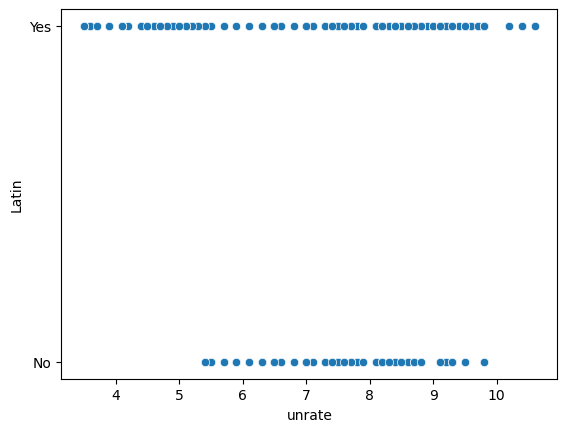

In [335]:
seaborn.scatterplot (data= unemployaward_df, x = unemployaward_df['unrate'], y = unemployaward_df['Latin'])

Linear Regression on the rate of unemployment and the frequency of the song on Hot100

In [336]:
x= simplecomp_df['unrate']
y= simplecomp_df['songfreq']
x= np.array(x.values).reshape(-1,1)
y= np.array(y.values).reshape(-1,1)
linx_train = x[:-20]
linx_test = x[-20:]
liny_train = y[:-20]
liny_test = y[-20:]
pitbull_linreg = LinearRegression()
pitbull_linreg.fit(linx_train, liny_train)
slope= float(pitbull_linreg.coef_)
intercept= float(pitbull_linreg.intercept_)
print ("The model's slope is", slope)
print ('Intercept:', intercept)

The model's slope is 0.022932848064513855
Intercept: 1.430183929949853


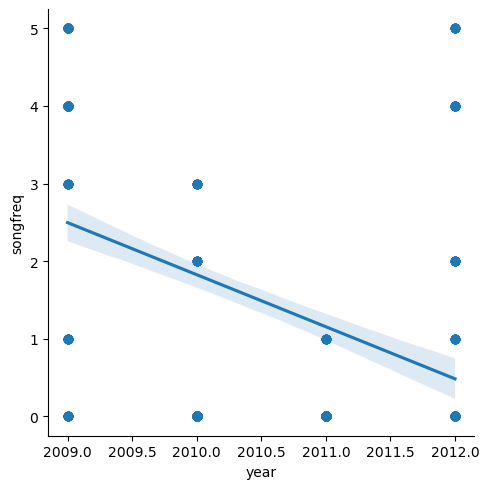

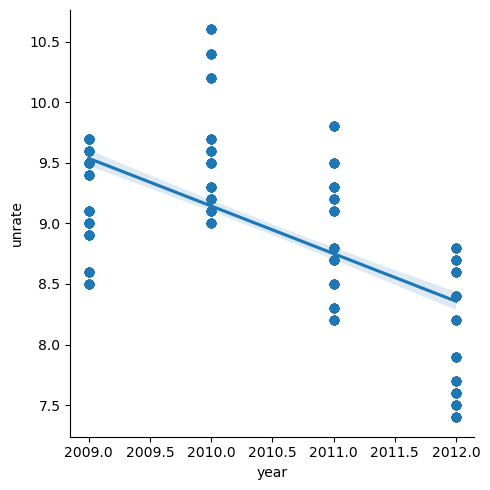

In [337]:
seaborn.lmplot(x= "year", y= 'songfreq', data=simplecomp_df)
seaborn.lmplot(x= "year", y= 'unrate', data=simplecomp_df)

### Exploratory data: Finding out the mean, median, variance, standard deviation of data concerning unemployment and Pitbull's appearances on Billboard Hot 100 

Exploratory data concerning the frequency of Pitbull's music on Hot 100

In [338]:
billboard_freq_means = (simplecomp_df['songfreq'].mean(axis=0))
print ('billboard_freq_means')
print (billboard_freq_means)
billboard_freq_median= (simplecomp_df['songfreq'].median(axis=0))
print ('billboard_freq_median')
print (billboard_freq_median)
billboard_freq_variances= (simplecomp_df['songfreq'].var(axis=0))
print ('billboard_freq_variances')
print (billboard_freq_variances)
billboard_freq_std= (simplecomp_df['songfreq'].std(axis=0))
print ('billboard_freq_std')
print (billboard_freq_std)

billboard_freq_means
1.5849056603773586
billboard_freq_median
0.0
billboard_freq_variances
3.9093151091962697
billboard_freq_std
1.9771988036604387


Exploratory data concerning the unemployment rate between 2009 and 2012

In [339]:
unrate_means = (simplecomp_df['unrate'].mean(axis=0))
print ('unrate_means')
print (unrate_means)
unrate_median= (simplecomp_df['unrate'].median(axis=0))
print ('unrate_median')
print (unrate_median)
unrate_variances= (simplecomp_df['unrate'].var(axis=0))
print ('unrate_variances')
print (unrate_variances)
unrate_std= (simplecomp_df['unrate'].std(axis=0))
print ('unrate_std')
print (unrate_std)

unrate_means
9.002515723270431
unrate_median
9.1
unrate_variances
0.5230172832169558
unrate_std
0.7231993385069955


■ Data description. Have an initial draft of your data description section.
Your data description should be about your analysis-ready data.
- Our data consists of csv files from Kaggle, noting unemployment data and Billboard Hot 100 data. Additionally, we underwent webscraping to collect Wikipedia data on Pitbull's billboard awards.
■ Data limitations. Identify any potential problems with your dataset.
- It could be very limited, because there are other metrics for popularity than Billboard Hot 100, like Spotify and Apple music. Additionally, because it's so niche, there is not a large amount of Pitbull popularity to draw on.
■ Exploratory data analysis. Perform an (initial) exploratory data analysis.
- It shows pretty weak correlation.
- Show more mean, median, variance
■ Questions for reviewers. List specific questions for your peer reviewers
- How can we make this more substantive?
- How can we implement the awards dataframe in a manner to tell a story with data?
